# Harnessing Machine Learning for Healthcare: Predicting Death Events of Patients with Prior Heart Failure

## Modeling

One of machine learning's most significant applications is diagnosing and predicting future outcomes of patients, given their demographics and medical histories. By harnessing the data to classify patients as "high risk", healthcare professionals can administer more specialized care and implement proactive measures to save the lives of many.

This project aims to analyze the characteristics of 299 patients who have experienced heart failure. The target variable of the dataset is a death event, denoting whether a patient died during the follow-up period. Patient features include demographics like age and sex, along with medical statistics like CPK level, platelet count, and etc. Following the exploratory data analysis (EDA), modeling will be performed using a multitude of different machine learning models to compare and achieve the highest accuracy. Lastly, a dashboard will be implemented to showcase key statistics, modeling outcomes, and predictions on input patient statistics.

In [1]:
__author__ = 'Jared Paul Guevara'

In [2]:
# Import necessary libraries and packages for modeling, pipelining, and generating results
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

train = pd.read_csv('data/heart_failure_train.csv')
train.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,death_event
0,75.0,0,582,0,45,1,263358.03,1.18,137,1,0,87,0
1,65.0,0,113,1,25,0,497000.00,1.83,135,1,0,67,1
2,85.0,0,23,0,45,0,360000.00,3.00,132,1,0,28,1
3,70.0,1,171,0,60,1,176000.00,1.10,145,1,1,146,0
4,75.0,1,582,0,30,0,225000.00,1.83,134,1,0,113,1


In [3]:
# Import and display the heads of training sets of features and predictor variable
X_train = train.iloc[:, :-1]
display(X_train.head())

y_train = train.iloc[:, -1]
y_train.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time
0,75.0,0,582,0,45,1,263358.03,1.18,137,1,0,87
1,65.0,0,113,1,25,0,497000.00,1.83,135,1,0,67
2,85.0,0,23,0,45,0,360000.00,3.00,132,1,0,28
3,70.0,1,171,0,60,1,176000.00,1.10,145,1,1,146
4,75.0,1,582,0,30,0,225000.00,1.83,134,1,0,113


0    0
1    1
2    1
3    0
4    1
Name: death_event, dtype: int64

In [4]:
# Import the testing sets of features and predictor variable
X_test = pd.read_csv('data/heart_failure_X_test.csv')
y_test = pd.read_csv('data/heart_failure_y_test.csv')

Classificaition is defined as a "supervised machine learning technique where the model learns to predict the label of given input data." For the case of our dataset, we are aiming to predict whether or not a patient survives, given the set of features explored in the previous notebook.

Classification can be performed by a wide variety of models and choosing one can depend on the use case, size of the dataset, efficiency constraints, etc. 

For our modeling process, we will test three models: logistic regression, support vector classification, and random forest classifier. Each model's default hyperparameters will be tested to identify the highest training/cross-validation score. The best performing model will be then be used for further optimization.

In [5]:
# Create pipelines for each potential model by first scaling each feature, then fitting to a binary classifier
log_pipe = make_pipeline(StandardScaler(), LogisticRegression())
svc_pipe = make_pipeline(StandardScaler(), SVC())
rfc_pipe = make_pipeline(StandardScaler(), RandomForestClassifier())

# Dictionary for converting index to model name for results
model_names = {0 : "Logistic Regression",
               1 : "Support Vector Classifier",
               2 : "Random Forest Classifier"}

# For each model, fit training data, generate training predictions, and calculate training and cross-validation accuracies
models = [log_pipe, svc_pipe, rfc_pipe]
preds = []
for model in models:
    model.fit(X_train, y_train)
    train_preds = model.predict(X_train)
    # Save predictions as a tuple of training accuracy and cross-validation accuracy
    preds.append((round(accuracy_score(train_preds, y_train), 2), round(cross_val_score(model, X_train, y_train, cv=10).mean(), 2)))

# Loop through the results and print the accuracy metrics for each model
for i, pred in enumerate(preds):
    print(f'Accuracy metrics of {model_names[i]} model:\nTraining accuracy: {pred[0]}\nCross-validation accuracy across 10 folds: {pred[1]}\n')

Accuracy metrics of Logistic Regression model:
Training accuracy: 0.87
Cross-validation accuracy across 10 folds: 0.83

Accuracy metrics of Support Vector Classifier model:
Training accuracy: 0.92
Cross-validation accuracy across 10 folds: 0.8

Accuracy metrics of Random Forest Classifier model:
Training accuracy: 1.0
Cross-validation accuracy across 10 folds: 0.87



Considering that the Random Forest Classifier had the highest training and cross-validation accuracy, this will be the model used to predict patient outcomes, but not before performing some hyperparameter optimization. To do so, a randomized search of parameters will be performed using sklearn's `RandomizedSearchCV` function, which allows a range of input parameters to be searched through randomly, in order to identify the best performing values.

In [6]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_dist = {
    'n_estimators': randint(1, 1000),
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': randint(1, 10),
    'min_samples_split': randint(1, 10),
    'min_samples_leaf': randint(2, 10),
    'max_leaf_nodes': randint(1, 100),
    'max_features': ['sqrt', 'log2', 12, 6],
    'class_weight': [None, 'balanced', 'balanced_subsample']
}

rfc = RandomForestClassifier()

rand_search = RandomizedSearchCV(rfc, param_distributions=param_dist, scoring='accuracy', cv=10, random_state=42)
rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(),
                   param_distributions={'class_weight': [None, 'balanced',
                                                         'balanced_subsample'],
                                        'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f67edf0b790>,
                                        'max_features': ['sqrt', 'log2', 12, 6],
                                        'max_leaf_nodes': <scipy.stats._distn_infrastruct...rozen object at 0x7f67edea2790>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f67edf09bd0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f67edf08bd0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f67effa4b90>},
                   random_state=42, scoring='accuracy')

In [7]:
optimal_params = rand_search.best_params_
optimal_pipe = make_pipeline(StandardScaler(), RandomForestClassifier(**optimal_params))

optimal_pipe.fit(X_train, y_train)
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)
print(f'Optimal model metrics:\nTraining accuracy: {accuracy_score(train_preds, y_train)}\nCross-validation accuracy: {round(cross_val_score(model, X_train, y_train, cv=10).mean(), 2)}\nTesting accuracy: {round(accuracy_score(test_preds, y_test), 2)}')

Optimal model metrics:
Training accuracy: 1.0
Cross-validation accuracy: 0.88
Testing accuracy: 0.75


Our final model was able to achieve a testing accuracy of 0.75, but two important metrics of binary classification are F1 score and the ROC curve. F1 score is the harmonic mean between precision and recall, which are both performance metrics that describe positive predictive value and sensitivity of the model. The receiver operating curve (ROC) plots the true positive rate vs. the false positive rate, which allows for the performance of the model to be viewed visually. An area under the curve (AUC) closer to 1.0 is indicative of a strong model, whereas an AUC closer to 0.5 would mean that the model has no better predictive value than a random classifer.

F1 score of model: 0.64


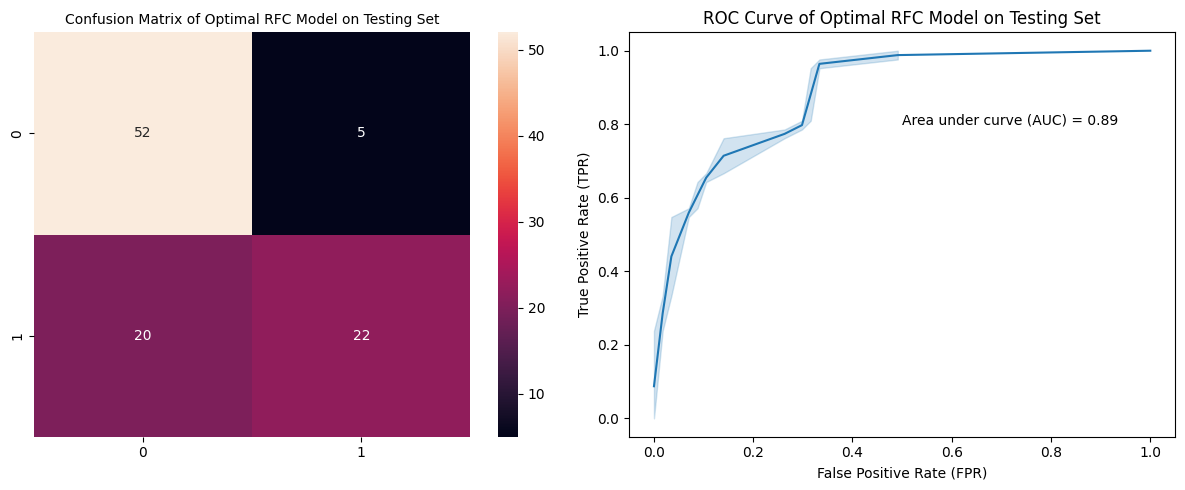

In [8]:
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc

# F1 Score
print(f'F1 score of model: {round(f1_score(y_test, test_preds), 2)}')

# Create subplots side-by-side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns, adjust figure size as needed

# Confusion Matrix
sns.heatmap(pd.DataFrame(confusion_matrix(y_test, test_preds)), annot=True, ax=axes[0])
axes[0].set_title('Confusion Matrix of Optimal RFC Model on Testing Set', fontsize=10)

# ROC Curve
test_probs = optimal_pipe.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, test_probs)
sns.lineplot(x=fpr, y=tpr, ax=axes[1])
axes[1].annotate(f'Area under curve (AUC) = {round(auc(fpr, tpr), 2)}', (0.5, 0.8))
axes[1].set_xlabel('False Positive Rate (FPR)')
axes[1].set_ylabel('True Positive Rate (TPR)')
axes[1].set_title('ROC Curve of Optimal RFC Model on Testing Set')

# Adjust layout
plt.tight_layout()
plt.show()

Great! With our model performing well, we can go ahead and save it via Python's pickle module, which can store models in its own `.pkl` file. This model can then be used to make predictions, given that the input data has all of the features included.

In [9]:
import pickle

with open('heart_failure_predictor.pkl','wb') as f:
    pickle.dump(optimal_pipe, f)